In [41]:
from pr2_utils import *
import cv2
import open3d as o3d

In [42]:
dataset = 21
odo_str = "icp"

with np.load(f"../data/Hokuyo{dataset}.npz") as data:
    lidar_ranges = data["ranges"].T       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load(f"../data/odometry_{odo_str}_{dataset}.npz") as data:
    odometry = data["X"]
    odometry_stamp = data["stamps"]

f_odometry = InterpN1D(odometry_stamp, odometry)

In [43]:
map_resolution = 20
map_size = (np.ceil((np.max(odometry, axis=0)-np.min(odometry, axis=0))[:2] + lidar_range_max)).astype(int)[::-1] * map_resolution 
map_center= (np.ceil(-np.min(odometry, axis=0)[:2] + 0.5*lidar_range_max)).astype(int)[::-1] * map_resolution

map_size, map_center

(array([1040, 1000]), array([380, 400]))

# Occupancy map

In [44]:
occupancy_map = np.zeros(map_size, dtype=int)
# bar = tqdm(range(0,100))
bar= tqdm(range(lidar_stamps.shape[0]))
for i in bar:
    pc_coord_body = lidar_scan_to_3dpc(lidar_ranges[i])
    
    odo = f_odometry(lidar_stamps[i])
    wTo = odometry_to_transformation(odo)
    r, t = get_Rt(wTo)
    pc_coord_world = (r @ pc_coord_body.T).T + t
    pc_coord_map = map_resolution*pc_coord_world[:,:2] + map_center

    lines = []
    sx, sy = (map_resolution*odo[:2]+ map_center).astype(int)
    for point in pc_coord_map.astype(int):
        ex, ey = point.astype(int)
        lines.append(bresenham2D(sx, sy, ex, ey).T.astype(int))
    empty_points = np.unique(np.vstack(lines), axis=0, return_index=False)
    valid_mask = (0 <= empty_points[:, 0]) & (empty_points[:, 0] < occupancy_map.shape[1]) & \
        (0 <= empty_points[:, 1]) & (empty_points[:, 1] < occupancy_map.shape[0])
    filtered_points = empty_points[valid_mask]
    occupancy_map[filtered_points[:, 1], filtered_points[:, 0]] -= 1

    endpoints = pc_coord_map.astype(int)
    endpoint_mask = (0 <= endpoints[:, 0]) & (endpoints[:, 0] < occupancy_map.shape[1]) & \
                    (0 <= endpoints[:, 1]) & (endpoints[:, 1] < occupancy_map.shape[0])
    filtered_endpoints = endpoints[endpoint_mask]
    occupancy_map[filtered_endpoints[:, 1], filtered_endpoints[:, 0]] += 4


100%|██████████| 4785/4785 [02:41<00:00, 29.65it/s]


/tmp/ipykernel_1108/112952259.py:1: RuntimeWarning: overflow encountered in exp
  probability_map = 1 / (1 + np.exp(-occupancy_map, dtype=np.float64))


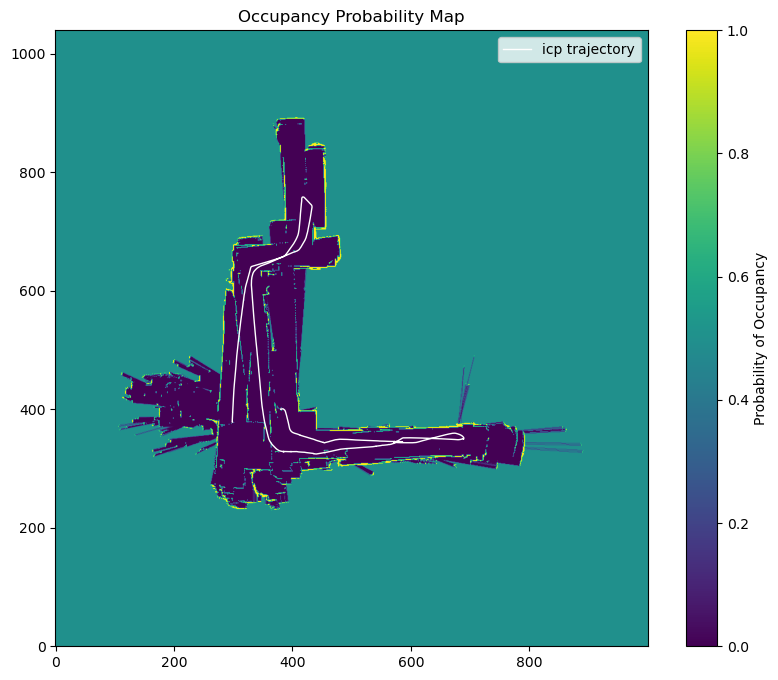

In [45]:
probability_map = 1 / (1 + np.exp(-occupancy_map, dtype=np.float64))
# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(probability_map, cmap='viridis', origin='lower')
plt.colorbar(label='Probability of Occupancy')
plt.title('Occupancy Probability Map')

odometry_map = map_resolution*odometry[:,:2] + map_center
plt.plot(odometry_map[:,0], odometry_map[:,1], color='white', linewidth=1, label=f'{odo_str} trajectory')
plt.legend()
plt.show()

# texture mapping

using disp time stamp as the standard time

In [46]:
with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

f_rgb_index = interp1d(rgb_stamps, np.arange(1, rgb_stamps.shape[0]+1), kind='nearest')

In [47]:
def rgbd_to_3dpc(d_img, rgb_img, disparity_max=1088, step=2):
    '''
    input: RGBD img.
    return: coords in camera frame, and their associated rgb values
    '''
    disparity = d_img[::step, ::step].flatten().astype(np.float32)
    d_mask = disparity < disparity_max
    dd = (-0.00304 * disparity[d_mask] + 3.31)
    z = 1.03 / dd
    
    v,u = np.mgrid[
        0:d_img.shape[0]:step,
        0:d_img.shape[1]:step
    ]
    u = u.flatten()[d_mask]
    v = v.flatten()[d_mask]

    # get 3D coordinates 
    fx = 585.05108211
    fy = 585.05108211
    cx = 315.83800193
    cy = 242.94140713
    x = (u-cx) / fx * z
    y = (v-cy) / fy * z
    
    # calculate the location of each pixel in the RGB image
    rgb_u = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
    rgb_v = np.round((v * 526.37 + 16662.0)/fy)
    valid_mask = (0<=rgb_u)&(rgb_u < rgb_img.shape[1])&(0<=rgb_v)&(rgb_v<rgb_img.shape[0])
    rgb = rgb_img[rgb_v[valid_mask].astype(int), rgb_u[valid_mask].astype(int)]

    pc_coord_camera = np.stack([z,-x,-y], axis=-1)[valid_mask]

    # roll, pitch, yaw = 0, 0.36, 0.021
    # R_pitch = np.array([[np.cos(pitch), 0, np.sin(pitch)],
    #                     [0, 1, 0],
    #                     [-np.sin(pitch), 0, np.cos(pitch)]])
    # R_yaw = np.array([[np.cos(yaw), -np.sin(yaw), 0],
    #                     [np.sin(yaw), np.cos(yaw), 0],
    #                     [0, 0, 1]])
    # R = R_yaw @ R_pitch
    bRc = np.array([
        [ 0.93569047, -0.02099846,  0.35219656],
        [ 0.01965239,  0.99977951,  0.00739722],
        [-0.35227423,  0.        ,  0.93589682]
    ])
    t = np.array([0.18, 0.005, 0.36])
    points_robot_center_frame = pc_coord_camera@bRc.T + t

    return points_robot_center_frame, rgb

def o3d_visualize_points(points, colors):
    """
    Visualize 3D points with colors using Open3D.
    
    Parameters:
    - points: np.array of shape (n, 3), where n is the number of points.
    - colors: np.array of shape (n, 3), representing RGB colors normalized between 0 and 1.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors/255)
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
    o3d.visualization.draw_geometries([pcd, coordinate_frame])

In [48]:
all_coord = []
all_rgb = []
floor_map = np.zeros([*map_size,3], dtype=int)

bar = tqdm(range(1, disp_stamps.shape[0], 2))
# bar = tqdm(range(1, 2))
for disp_index in bar:
    # handle rgb-d mismatch
    try:
        rgb_index = int(f_rgb_index(disp_stamps[disp_index]))
    except ValueError:
        continue
    if rgb_index > rgb_stamps.shape[0]:
        continue

    d_path = f"../data/dataRGBD/Disparity{dataset}/disparity{dataset}_{disp_index}.png"
    d_img = cv2.imread(d_path, cv2.IMREAD_UNCHANGED)
    rgb_path = f"../data/dataRGBD/RGB{dataset}/rgb{dataset}_{rgb_index}.png"
    rgb_img = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)[...,::-1] # correct order of RGB
    # get world point cloud
    pc_coord_body, rgb = rgbd_to_3dpc(d_img, rgb_img, step=2)
    wTo = odometry_to_transformation(f_odometry(disp_stamps[disp_index]))
    r, t = get_Rt(wTo)
    pc_coord_world = (pc_coord_body @ r.T) + t

    # for floor mapping
    floor_mask = np.abs(pc_coord_world[:,2])<0.5
    pc_coord_map = (map_resolution*pc_coord_world[floor_mask,:2] + map_center).astype(int)
    valid_mask = (0<=pc_coord_map[:,0]) & (pc_coord_map[:,0]<floor_map.shape[1]) & \
                 (0<=pc_coord_map[:,1]) & (pc_coord_map[:,1]<floor_map.shape[0])
    floor_map[pc_coord_map[:, 1][valid_mask], pc_coord_map[:, 0][valid_mask]] = rgb[floor_mask][valid_mask]

    # for 3d pc cloud
    all_coord.append(pc_coord_world)
    all_rgb.append(rgb)


  0%|          | 0/1094 [00:00<?, ?it/s]

100%|██████████| 1094/1094 [00:18<00:00, 57.69it/s]


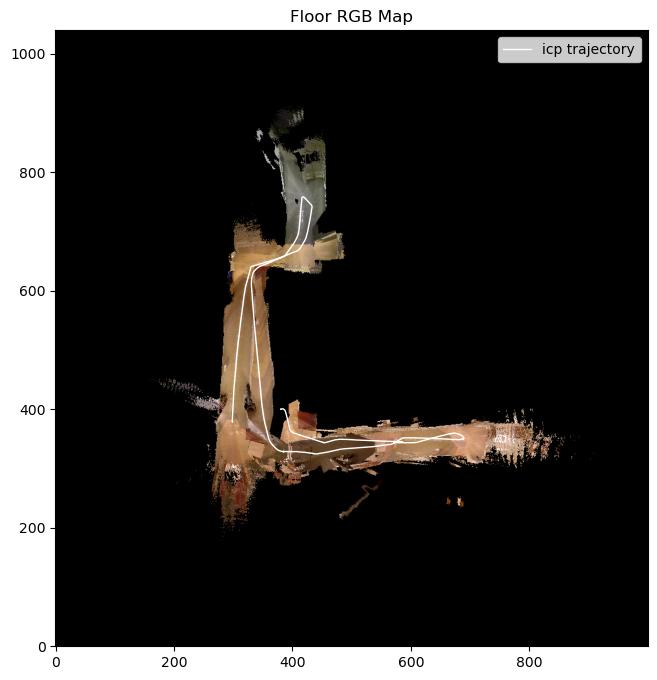

In [49]:
# for floor mapping
plt.figure(figsize=(10,8))
plt.imshow(floor_map, origin='lower')
plt.title('Floor RGB Map')
odometry_map = map_resolution*odometry[:,:2] + map_center
plt.plot(odometry_map[:,0], odometry_map[:,1], color='white', linewidth=1, label=f'{odo_str} trajectory')
plt.legend()
plt.show()

In [50]:
# for 3d pc cloud
# o3d_visualize_points(np.concatenate(all_coord), np.concatenate(all_rgb))